# 1. Import libraries

In [1]:
import os

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, count, mean, expr, when, coalesce

from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.clustering import KMeans
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

# data visualization
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# 2. Spark Session Creation

In [2]:
spark = SparkSession.builder.appName("VideoGameSalesAnalysis").getOrCreate()

# 3. Load data

In [3]:
# path to data
data_path = "dataset/Video_Games_Sales_as_at_22_Dec_2016.csv"

In [4]:
df_raw_data = spark.read.csv(data_path, header=True, inferSchema=True)

# 4. Data Exloration

## 4.1 Show top 5 rows

In [5]:
df_raw_data.show(5)

+--------------------+--------+---------------+------------+---------+--------+--------+--------+-----------+------------+------------+------------+----------+----------+---------+------+
|                Name|Platform|Year_of_Release|       Genre|Publisher|NA_Sales|EU_Sales|JP_Sales|Other_Sales|Global_Sales|Critic_Score|Critic_Count|User_Score|User_Count|Developer|Rating|
+--------------------+--------+---------------+------------+---------+--------+--------+--------+-----------+------------+------------+------------+----------+----------+---------+------+
|          Wii Sports|     Wii|           2006|      Sports| Nintendo|   41.36|   28.96|    3.77|       8.45|       82.53|          76|          51|         8|       322| Nintendo|     E|
|   Super Mario Bros.|     NES|           1985|    Platform| Nintendo|   29.08|    3.58|    6.81|       0.77|       40.24|        NULL|        NULL|      NULL|      NULL|     NULL|  NULL|
|      Mario Kart Wii|     Wii|           2008|      Racing|

## 4.2 Print schema

In [6]:
df_raw_data.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Platform: string (nullable = true)
 |-- Year_of_Release: string (nullable = true)
 |-- Genre: string (nullable = true)
 |-- Publisher: string (nullable = true)
 |-- NA_Sales: double (nullable = true)
 |-- EU_Sales: double (nullable = true)
 |-- JP_Sales: double (nullable = true)
 |-- Other_Sales: double (nullable = true)
 |-- Global_Sales: double (nullable = true)
 |-- Critic_Score: integer (nullable = true)
 |-- Critic_Count: integer (nullable = true)
 |-- User_Score: string (nullable = true)
 |-- User_Count: integer (nullable = true)
 |-- Developer: string (nullable = true)
 |-- Rating: string (nullable = true)



## 4.3 Summary of the data, like count, mean, min, max

In [7]:
df_raw_data.describe().show()

+-------+--------------------+--------+------------------+--------+---------------+------------------+-------------------+-------------------+-------------------+------------------+-----------------+------------------+------------------+------------------+---------------+------+
|summary|                Name|Platform|   Year_of_Release|   Genre|      Publisher|          NA_Sales|           EU_Sales|           JP_Sales|        Other_Sales|      Global_Sales|     Critic_Score|      Critic_Count|        User_Score|        User_Count|      Developer|Rating|
+-------+--------------------+--------+------------------+--------+---------------+------------------+-------------------+-------------------+-------------------+------------------+-----------------+------------------+------------------+------------------+---------------+------+
|  count|               16717|   16719|             16719|   16717|          16719|             16719|              16719|              16719|              1671

## 4.4 Distinct count of each columns

In [8]:
for column in df_raw_data.columns:
    col_cnt = df_raw_data.select(column).distinct().count()
    print(f"Count Distinct {column}: {col_cnt}")

Count Distinct Name: 11563
Count Distinct Platform: 31
Count Distinct Year_of_Release: 40
Count Distinct Genre: 13
Count Distinct Publisher: 582
Count Distinct NA_Sales: 402
Count Distinct EU_Sales: 307
Count Distinct JP_Sales: 244
Count Distinct Other_Sales: 155
Count Distinct Global_Sales: 629
Count Distinct Critic_Score: 83
Count Distinct Critic_Count: 107
Count Distinct User_Score: 97
Count Distinct User_Count: 889
Count Distinct Developer: 1697
Count Distinct Rating: 9


## 4.4 Count of each columns without null values

In [9]:
not_null_counts = df_raw_data.select([sum((~col(c).isNull()).cast("int")).alias(c) for c in df_raw_data.columns])
not_null_counts.show()

+-----+--------+---------------+-----+---------+--------+--------+--------+-----------+------------+------------+------------+----------+----------+---------+------+
| Name|Platform|Year_of_Release|Genre|Publisher|NA_Sales|EU_Sales|JP_Sales|Other_Sales|Global_Sales|Critic_Score|Critic_Count|User_Score|User_Count|Developer|Rating|
+-----+--------+---------------+-----+---------+--------+--------+--------+-----------+------------+------------+------------+----------+----------+---------+------+
|16717|   16719|          16719|16717|    16719|   16719|   16719|   16719|      16719|       16719|        8137|        8137|     10015|      7590|    10096|  9950|
+-----+--------+---------------+-----+---------+--------+--------+--------+-----------+------------+------------+------------+----------+----------+---------+------+



### 4.4.1 Plotting above ditribution in bar graph

In [10]:
# Convert the PySpark DataFrame to Pandas DataFrame and transpose it
not_null_counts_pandas = not_null_counts.toPandas().transpose()

# Create the bar plot using Plotly
fig = go.Figure()

# Adding bar traces for each column in the transposed DataFrame
for column in not_null_counts_pandas.columns:
    fig.add_trace(go.Bar(
        x=not_null_counts_pandas.index,
        y=not_null_counts_pandas[column],
        name=column
    ))

# Customizing the layout
fig.update_layout(
    barmode='stack',
    title="Product Value Counts in Columns",
    xaxis_title="Columns",
    yaxis_title="Number of Null Values",
    template='plotly',
    showlegend=False,
    colorway=px.colors.sequential.Greens_r
)

# Adding the upper limit line
upper_limit = df_raw_data.count()
fig.add_hline(y=upper_limit, line_dash="dash", line_color="darkgreen", annotation_text="Upper Limit", annotation_position="top right")

# Show the plot
fig.show()


# 5. Data Cleaning and Preprocessing

## 5.1 Missing Values:

### 5.1.1 Identify Missing Values:

In [11]:
not_null_counts = df_raw_data.select([sum((~col(c).isNull()).cast("int")).alias(c) for c in df_raw_data.columns])
not_null_counts.show()

+-----+--------+---------------+-----+---------+--------+--------+--------+-----------+------------+------------+------------+----------+----------+---------+------+
| Name|Platform|Year_of_Release|Genre|Publisher|NA_Sales|EU_Sales|JP_Sales|Other_Sales|Global_Sales|Critic_Score|Critic_Count|User_Score|User_Count|Developer|Rating|
+-----+--------+---------------+-----+---------+--------+--------+--------+-----------+------------+------------+------------+----------+----------+---------+------+
|16717|   16719|          16719|16717|    16719|   16719|   16719|   16719|      16719|       16719|        8137|        8137|     10015|      7590|    10096|  9950|
+-----+--------+---------------+-----+---------+--------+--------+--------+-----------+------------+------------+------------+----------+----------+---------+------+



### 5.1.2 Handling Missing Values (Example - Mean Imputation for Numerical Features):

In [12]:

# Fill Critic_Score and User_Score with their respective means
mean_critic_score = df_raw_data.select(mean(col('Critic_Score'))).collect()[0][0]
mean_user_score = df_raw_data.select(mean(col('User_Score'))).collect()[0][0]
df_filled_scores = df_raw_data.fillna({'Critic_Score': mean_critic_score, 'User_Score': mean_user_score})

# Fill Critic_Count and User_Count with their respective medians
median_critic_count = df_filled_scores.select(expr('percentile_approx(Critic_Count, 0.5)').alias('median')).collect()[0][0]
median_user_count = df_filled_scores.select(expr('percentile_approx(User_Count, 0.5)').alias('median')).collect()[0][0]
df_filled_counts = df_filled_scores.fillna({'Critic_Count': median_critic_count, 'User_Count': median_user_count})

# Fill Developer with the mode or "Unknown"
mode_developer_row = df_filled_counts.groupBy('Developer').agg(count('*').alias('count')).orderBy('count', ascending=False).first()
mode_developer = mode_developer_row[0] if mode_developer_row and mode_developer_row[0] is not None else 'Unknown'
print(f"Mode Developer: {mode_developer}")
df_filled_developer = df_filled_counts.fillna({'Developer': mode_developer})

# Fill Rating with the mode or "Unknown"
mode_rating_row = df_filled_developer.groupBy('Rating').agg(count('*').alias('count')).orderBy('count', ascending=False).first()
mode_rating = mode_rating_row[0] if mode_rating_row and mode_rating_row[0] is not None else 'Unknown'
print(f"Mode Rating: {mode_rating}")
df_intermediate_cleaned = df_filled_developer.fillna({'Rating': mode_rating})

# df_cleaned = df_intermediate_cleaned.withColumn('Genre', coalesce(df_intermediate_cleaned['Genre'], 'Unknown'))
df_cleaned = df_intermediate_cleaned.where(col('Genre').isNotNull())

# Show the cleaned DataFrame
df_cleaned.show()


Mode Developer: Unknown
Mode Rating: Unknown
+--------------------+--------+---------------+------------+--------------------+--------+--------+--------+-----------+------------+------------+------------+------------------+----------+-------------------+-------+
|                Name|Platform|Year_of_Release|       Genre|           Publisher|NA_Sales|EU_Sales|JP_Sales|Other_Sales|Global_Sales|Critic_Score|Critic_Count|        User_Score|User_Count|          Developer| Rating|
+--------------------+--------+---------------+------------+--------------------+--------+--------+--------+-----------+------------+------------+------------+------------------+----------+-------------------+-------+
|          Wii Sports|     Wii|           2006|      Sports|            Nintendo|   41.36|   28.96|    3.77|       8.45|       82.53|          76|          51|                 8|       322|           Nintendo|      E|
|   Super Mario Bros.|     NES|           1985|    Platform|            Nintendo|  

In [13]:
df_cleaned_not_null_counts = df_cleaned.select([sum((~col(c).isNull()).cast("int")).alias(c) for c in df_cleaned.columns])
df_cleaned_not_null_counts.show()

+-----+--------+---------------+-----+---------+--------+--------+--------+-----------+------------+------------+------------+----------+----------+---------+------+
| Name|Platform|Year_of_Release|Genre|Publisher|NA_Sales|EU_Sales|JP_Sales|Other_Sales|Global_Sales|Critic_Score|Critic_Count|User_Score|User_Count|Developer|Rating|
+-----+--------+---------------+-----+---------+--------+--------+--------+-----------+------------+------------+------------+----------+----------+---------+------+
|16717|   16717|          16717|16717|    16717|   16717|   16717|   16717|      16717|       16717|       16717|       16717|     16717|     16717|    16717| 16717|
+-----+--------+---------------+-----+---------+--------+--------+--------+-----------+------------+------------+------------+----------+----------+---------+------+



# Descriptive Statistics

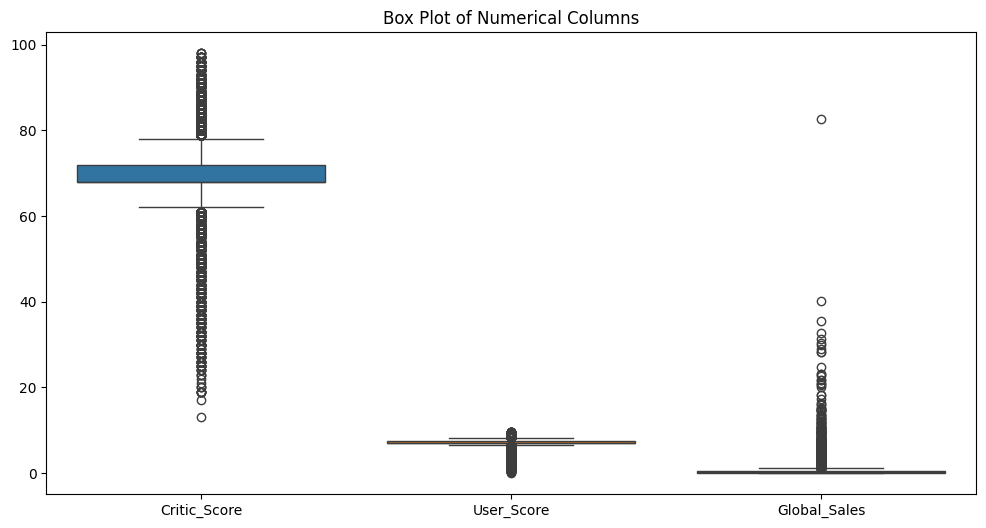

In [31]:
# Convert the PySpark DataFrame to a Pandas DataFrame
df_pandas = df_cleaned.toPandas()

# Replace 'tbd' with NaN
df_pandas['User_Score'] = df_pandas['User_Score'].replace('tbd', np.nan)

# Convert columns to numeric
df_pandas['Critic_Score'] = pd.to_numeric(df_pandas['Critic_Score'], errors='coerce')
df_pandas['User_Score'] = pd.to_numeric(df_pandas['User_Score'], errors='coerce')
df_pandas['Global_Sales'] = pd.to_numeric(df_pandas['Global_Sales'], errors='coerce')

# Drop rows with NaN values in the specified columns
df_pandas = df_pandas.dropna(subset=['Critic_Score', 'User_Score', 'Global_Sales'])

# Plot box plots for the numerical columns
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_pandas[['Critic_Score', 'User_Score', 'Global_Sales']])
plt.title('Box Plot of Numerical Columns')
plt.show()


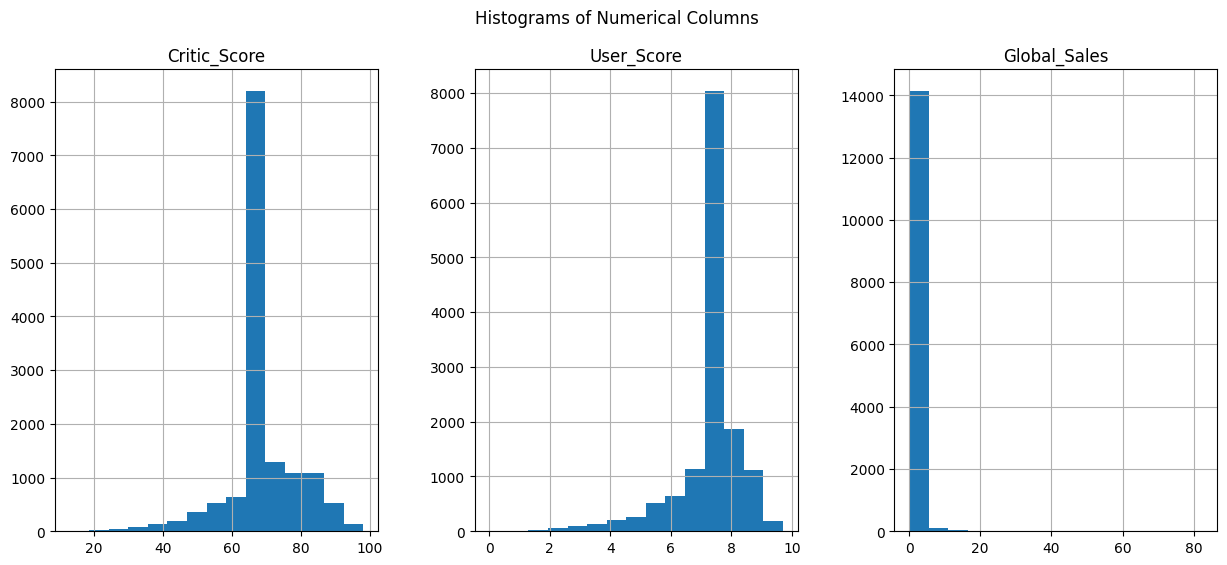

In [32]:
# Plot histograms for the numerical columns
df_pandas[['Critic_Score', 'User_Score', 'Global_Sales']].hist(bins=15, figsize=(15, 6), layout=(1, 3))
plt.suptitle('Histograms of Numerical Columns')
plt.show()

# Correlation Matrix

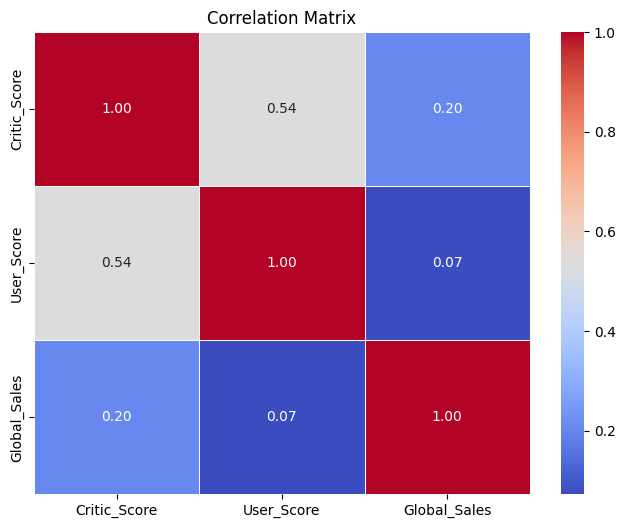

In [30]:
df_pandas = df_cleaned.toPandas()

# Replace 'tbd' with NaN
df_pandas['User_Score'] = df_pandas['User_Score'].replace('tbd', np.nan)

# Convert columns to numeric
df_pandas['Critic_Score'] = pd.to_numeric(df_pandas['Critic_Score'], errors='coerce')
df_pandas['User_Score'] = pd.to_numeric(df_pandas['User_Score'], errors='coerce')
df_pandas['Global_Sales'] = pd.to_numeric(df_pandas['Global_Sales'], errors='coerce')

# Drop rows with NaN values in the specified columns
df_pandas = df_pandas.dropna(subset=['Critic_Score', 'User_Score', 'Global_Sales'])

# Calculate the correlation
correlation = df_pandas[['Critic_Score', 'User_Score', 'Global_Sales']].corr(method='pearson')

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


# Visualization of Scores and Sales

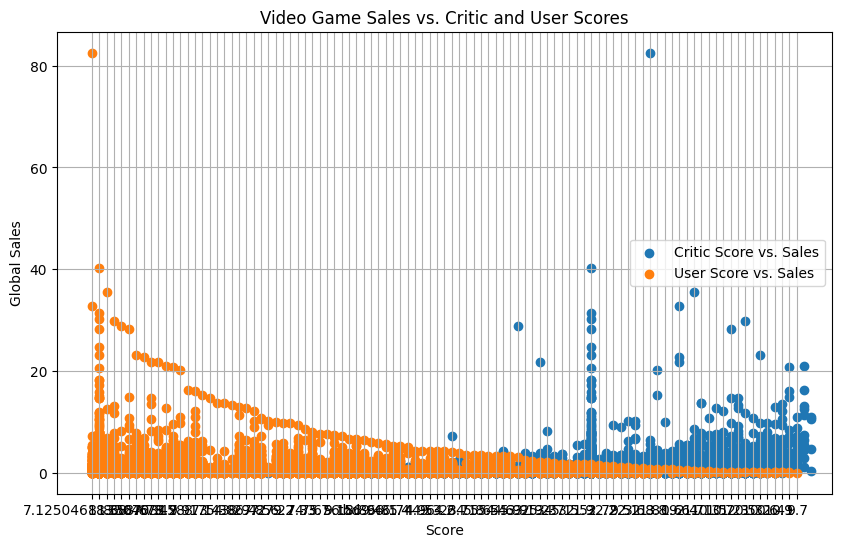

In [27]:
# Convert the PySpark DataFrame to a Pandas DataFrame
df_cleaned_pandas = df_cleaned.select('Critic_Score', 'User_Score', 'Global_Sales').toPandas()

plt.figure(figsize=(10, 6))

# Scatter plot for Critic Score vs. Global Sales
plt.scatter(df_cleaned_pandas['Critic_Score'], df_cleaned_pandas['Global_Sales'], label='Critic Score vs. Sales')

# Scatter plot for User Score vs. Global Sales
plt.scatter(df_cleaned_pandas['User_Score'], df_cleaned_pandas['Global_Sales'], label='User Score vs. Sales')

plt.xlabel('Score')
plt.ylabel('Global Sales')
plt.title('Video Game Sales vs. Critic and User Scores')
plt.legend()
plt.grid(True)
plt.show()


# 6. Regression Analysis

In [ ]:
# Convert User_Score and Year_of_Release to numerical data types
df_cleaned = df_cleaned.withColumn('User_Score', when(col('User_Score').cast('double').isNotNull(), col('User_Score').cast('double')).otherwise(0.0))
df_cleaned = df_cleaned.withColumn('Year_of_Release', when(col('Year_of_Release').cast('int').isNotNull(), col('Year_of_Release').cast('int')).otherwise(0))

# Prepare features and label
feature_columns = ['Critic_Score', 'User_Score', 'Year_of_Release']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
data_prepared = assembler.transform(df_cleaned).select('features', 'Global_Sales')

# Split the data into training and test sets
train_data, test_data = data_prepared.randomSplit([0.8, 0.2], seed=42)

# Initialize and train the model
lr = LinearRegression(featuresCol='features', labelCol='Global_Sales', predictionCol="predicted_sales")
lr_model = lr.fit(train_data)

# Make predictions and evaluate
predictions = lr_model.transform(test_data)
evaluator = RegressionEvaluator(labelCol='Global_Sales', predictionCol='predicted_sales')
rmse = evaluator.evaluate(predictions, {evaluator.metricName: 'rmse'})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: 'r2'})

print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R2): {r2}')

Root Mean Squared Error (RMSE): 1.3302292956352544
R-squared (R2): 0.0622347658558704


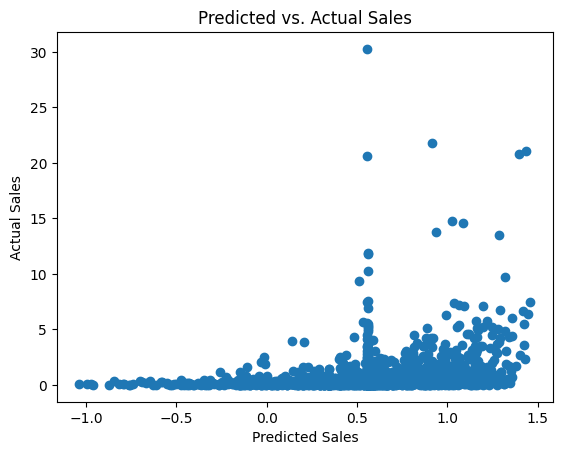

In [ ]:
# Access predicted sales from the model (assuming transform returns predictions)
predicted_sales = predictions.select("predicted_sales").toPandas()["predicted_sales"]

# Assuming actual sales are available in your data (replace with your column name)
actual_sales = test_data.select("Global_Sales").toPandas()["Global_Sales"]  # Assuming test data has actual sales

# Visualization code using the predicted_sales and actual_sales
plt.scatter(predicted_sales, actual_sales)
plt.xlabel("Predicted Sales")
plt.ylabel("Actual Sales")
plt.title("Predicted vs. Actual Sales")
plt.show()

# 7. K MEans Clustering

WSSSE for different k values:
k = 2, WSSSE = 2274834.6753119538
k = 3, WSSSE = 1540850.7127067551
k = 4, WSSSE = 1149267.6831890354
k = 5, WSSSE = 658441.1456548965
k = 6, WSSSE = 559182.0075667839
k = 7, WSSSE = 491107.9847688852
k = 8, WSSSE = 434342.8299801986
k = 9, WSSSE = 373807.1515344385
k = 10, WSSSE = 342173.55838749703


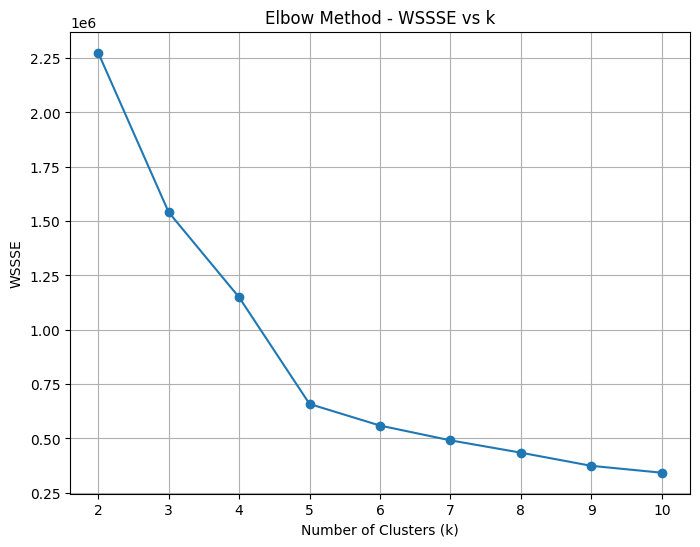

In [ ]:
data_prepared_clustering = assembler.transform(df_cleaned).select('features')
# Elbow Method
wcss = []
for k in range(2, 11):  # Start from k=2 (minimum clusters is 2)
  # Train KMeans model for current k
  kmeans = KMeans(k=k, seed=42)
  model = kmeans.fit(data_prepared_clustering)

  # Get WSSSE
  wssse = model.summary.trainingCost
  wcss.append(wssse)

# Print WSSSE for each k
print("WSSSE for different k values:")
for k, value in zip(range(2, 11), wcss):
  print(f"k = {k}, WSSSE = {value}")


# Prepare data for plotting
k_values = list(range(2, 11))  # Extract k values
wcss_values = wcss  # Extract WSSSE values

# Create the plot
plt.figure(figsize=(8, 6))  # Adjust figure size as desired
plt.plot(k_values, wcss_values, marker='o', linestyle='-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WSSSE')
plt.title('Elbow Method - WSSSE vs k')
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
chosen_k = 5

final_kmeans_model = KMeans(k=chosen_k, seed=42).fit(data_prepared_clustering)

# Make predictions (cluster assignments) for new data
predictions_clustering = final_kmeans_model.transform(data_prepared_clustering)

# Show clustering results
predictions_clustering.groupBy('prediction').count().show()

# Evaluate clustering by computing Within Set Sum of Squared Errors (WSSSE)
wssse = final_kmeans_model.summary.trainingCost
print(f'Within Set Sum of Squared Errors (WSSSE): {wssse}')


+----------+-----+
|prediction|count|
+----------+-----+
|         1|  269|
|         3| 2893|
|         4| 1600|
|         2| 3781|
|         0| 8174|
+----------+-----+

Within Set Sum of Squared Errors (WSSSE): 658441.1456548965


In [ ]:
# Save clustering results to CSV for Tableau
current_dir = os.getcwd()
subdirectory = 'output'
output_dir = os.path.join(current_dir, subdirectory)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f'Subdirectory {subdirectory} created.')

csv_path = os.path.join(output_dir, 'clustering_results.csv')
predictions_clustering.select('features', 'prediction').toPandas().to_csv(csv_path, index=False)
print(f"Clustering results CSV saved to: {csv_path}")

Clustering results CSV saved to: c:\Users\user\Code\STW7082CEM_Big_Data_Management_and_Data_Visualisation\output\clustering_results.csv


In [ ]:
data_prepared_pandas = predictions_clustering.select('features', 'prediction').toPandas()
features = np.array(data_prepared_pandas['features'].tolist())

pca = PCA(n_components=3)
reduced_features = pca.fit_transform(features)

fig = px.scatter_3d(data_prepared_pandas, x=reduced_features[:, 0], y=reduced_features[:, 1], z=reduced_features[:, 2], color=data_prepared_pandas['prediction'], opacity=0.8)
fig.update_layout(title='K-means Clustering Results (3D)')
fig.show()

# 8. Classification Analysis

In [ ]:
# Convert User_Score and Year_of_Release to numerical data types
df_cleaned = df_cleaned.withColumn('User_Score', when(col('User_Score').cast('double').isNotNull(), col('User_Score').cast('double')).otherwise(0.0))
df_cleaned = df_cleaned.withColumn('Year_of_Release', when(col('Year_of_Release').cast('int').isNotNull(), col('Year_of_Release').cast('int')).otherwise(0))

# Drop the Rating_Index column if it already exists
if 'Rating_Index' in df_cleaned.columns:
    df_cleaned = df_cleaned.drop('Rating_Index')

# Index the Rating column
indexer = StringIndexer(inputCol='Rating', outputCol='Rating_Index')
df_cleaned = indexer.fit(df_cleaned).transform(df_cleaned)

# Prepare features and label for classification
feature_columns = ['Critic_Score', 'User_Score', 'Year_of_Release']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
data_prepared_classification = assembler.transform(df_cleaned).select('features', 'Rating_Index')
data_prepared_classification.show(5)

# Split the data into training and test sets
train_data_class, test_data_class = data_prepared_classification.randomSplit([0.8, 0.2], seed=42)

# Initialize and train the model
rf = RandomForestClassifier(featuresCol='features', labelCol='Rating_Index')
rf_model = rf.fit(train_data_class)

# Make predictions and evaluate
predictions_class = rf_model.transform(test_data_class)
evaluator_class = MulticlassClassificationEvaluator(labelCol='Rating_Index', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator_class.evaluate(predictions_class)

print(f'Accuracy: {accuracy}')


+--------------------+------------+
|            features|Rating_Index|
+--------------------+------------+
|   [76.0,8.0,2006.0]|         1.0|
|[68.0,7.125046113...|         0.0|
|   [82.0,8.3,2008.0]|         1.0|
|   [80.0,8.0,2009.0]|         1.0|
|[68.0,7.125046113...|         0.0|
+--------------------+------------+
only showing top 5 rows

Accuracy: 0.6741057780495261


# 9. Confusion Matrix

In [ ]:
# Create and save confusion matrix
confusion_matrix = predictions_class.groupBy('Rating_Index', 'prediction').count()
confusion_matrix_pd = confusion_matrix.toPandas()
# confusion_matrix.show()

precision = evaluator_class.evaluate(predictions_class, {evaluator_class.metricName: 'weightedPrecision'})
recall = evaluator_class.evaluate(predictions_class, {evaluator_class.metricName: 'weightedRecall'})
f1 = evaluator_class.evaluate(predictions_class, {evaluator_class.metricName: 'f1'})

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Precision: 0.679074981912399
Recall: 0.6741057780495262
F1 Score: 0.6460748347523858


## 9.1. Save confusion matrix

In [ ]:
# Create a subdirectory inside the main code directory
subdirectory = 'output'
output_dir = os.path.join(current_dir, subdirectory)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f'Subdirectory {subdirectory} created.')

# Save confusion matrix to CSV in the subdirectory
output_path = os.path.join(output_dir, 'confusion_matrix.csv')
confusion_matrix.toPandas().to_csv(output_path, index=False)
print(f'Confusion matrix saved to {output_path}')

Confusion matrix saved to c:\Users\user\Code\STW7082CEM_Big_Data_Management_and_Data_Visualisation\output\confusion_matrix.csv


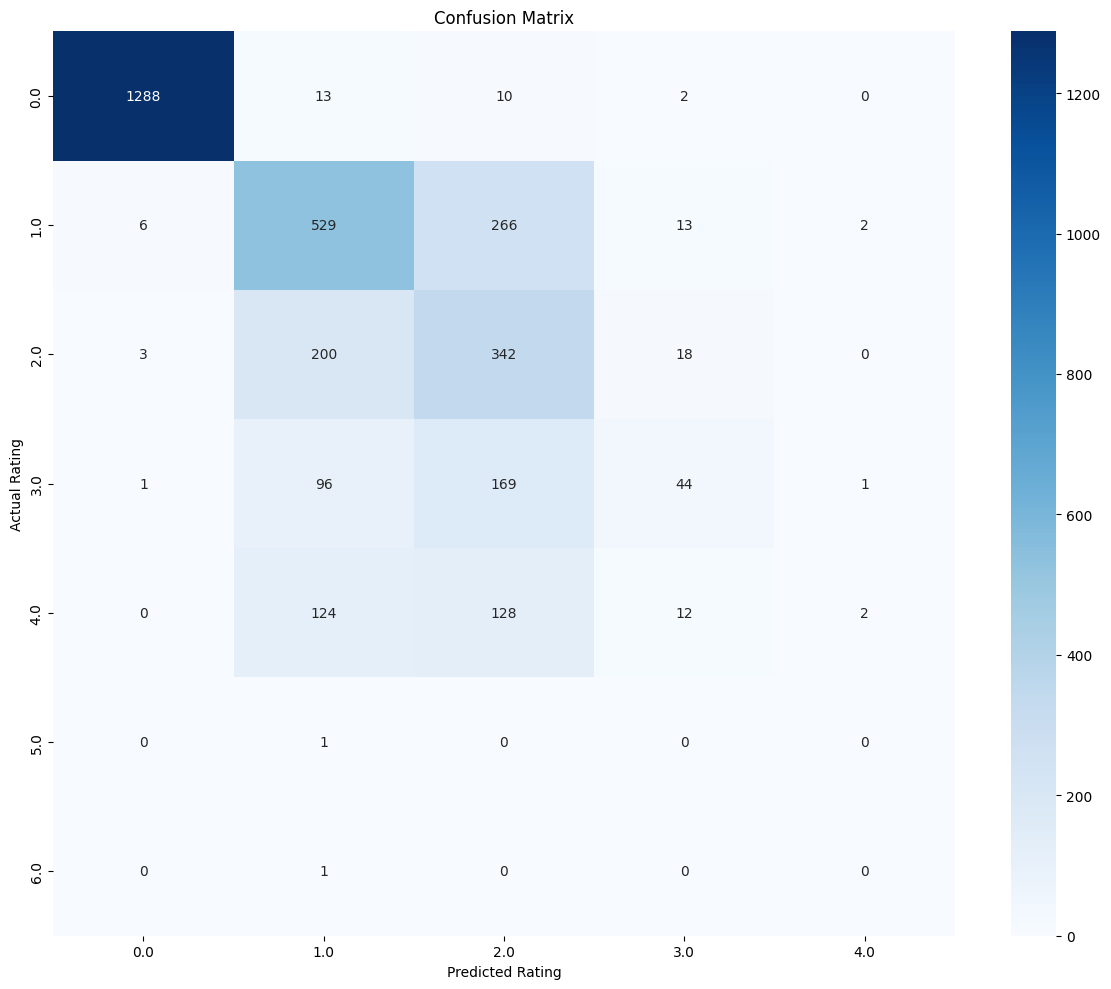

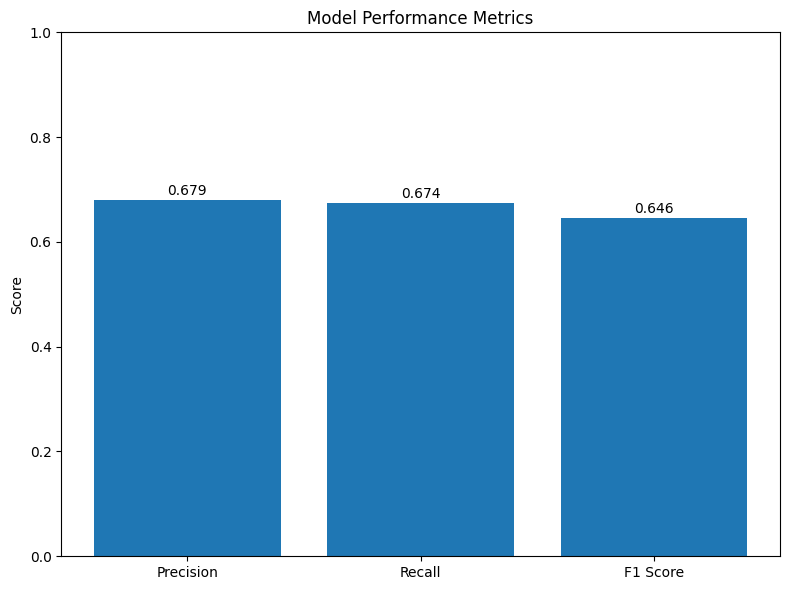

In [ ]:
# Create a pivot table for the confusion matrix
confusion_pivot = confusion_matrix_pd.pivot(index='Rating_Index', columns='prediction', values='count').fillna(0)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_pivot, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Rating')
plt.ylabel('Actual Rating')
plt.tight_layout()
plt.show()

# Plot the performance metrics
metrics = {'Precision': precision, 'Recall': recall, 'F1 Score': f1}
plt.figure(figsize=(8, 6))
plt.bar(metrics.keys(), metrics.values())
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
for i, v in enumerate(metrics.values()):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center')
plt.tight_layout()
plt.show()

# 10. Feature Importance

In [ ]:
# Get feature importances
importances = rf_model.featureImportances
feature_importance = [(feature, importance) for feature, importance in zip(feature_columns, importances)]
sorted_feature_importance = sorted(feature_importance, key=lambda x: x[1], reverse=True)

print("Feature Importances:")
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")

df_feature_importance = pd.DataFrame(sorted_feature_importance, columns=['Feature', 'Importance'])
csv_path = os.path.join(output_dir, 'feature_importance.csv')
df_feature_importance.to_csv(csv_path, index=False)
print(f"Feature importance CSV saved to: {csv_path}")

Feature Importances:
User_Score: 0.6773889376984694
Critic_Score: 0.29168254538688265
Year_of_Release: 0.030928516914647923
Feature importance CSV saved to: c:\Users\user\Code\STW7082CEM_Big_Data_Management_and_Data_Visualisation\output\feature_importance.csv


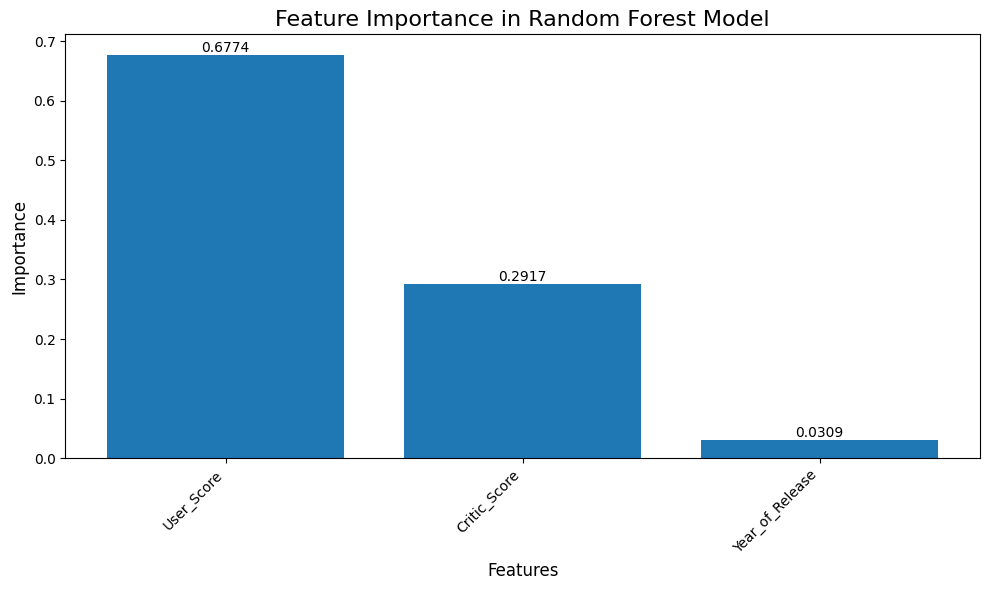

In [ ]:
# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(df_feature_importance['Feature'], df_feature_importance['Importance'])

# Customize the plot
plt.title('Feature Importance in Random Forest Model', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Add value labels on top of each bar
for i, v in enumerate(df_feature_importance['Importance']):
    plt.text(i, v, f'{v:.4f}', ha='center', va='bottom')

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Display the plot
plt.show()

# Stop Spark Session

In [ ]:
# spark.stop()